In [1]:
from google.colab import drive

drive.mount('/content/drive')
%cd './drive/MyDrive/project/xray/codes/'

Mounted at /content/drive
/content/drive/MyDrive/project/xray/codes


In [2]:
import torch
import os
from  model.model import *
import numpy as np
import matplotlib.pyplot as plt
from model.xray_dataloder import XrayDataset


In [3]:
model_dir = "..//results 1-50"
version = 'original_ssd_pretrained'
train_losses=torch.load( os.path.join(model_dir, 'train_losses_{}.pth'.format(version)))
val_losses=torch.load( os.path.join(model_dir, 'val_losses_{}.pth'.format(version)))
val_mAPs=torch.load( os.path.join(model_dir, 'val_mAPs_{}.pth'.format(version)))


path_pretrained_state_dict="..//best_vgg_state_dict.pth"
model = SSD300(4,path_pretrained_state_dict)
checkpoint = torch.load(os.path.join(model_dir, 'best_model_{}.pth'.format(version)))
model.load_state_dict(checkpoint['model_state_dict'])


Loaded base model.



<All keys matched successfully>

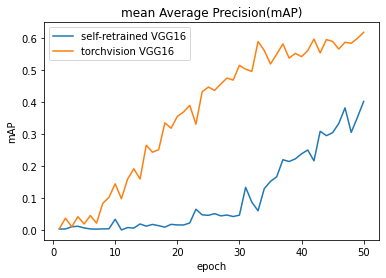

In [13]:
plt.plot(np.arange(len(val_mAPs))+1,np.array(val_mAPs))
plt.xlabel('epoch')
plt.ylabel('mAP')
plt.legend()
plt.title('mean Average Precision(mAP)')
plt.savefig(os.path.join(model_dir, 'map_100{}.png'.format(version)))
plt.show()

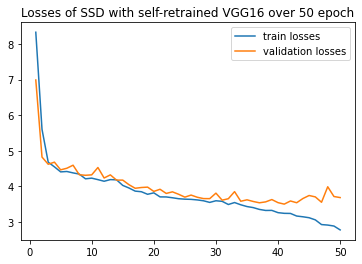

In [14]:
plt.plot(np.arange(len(train_losses))+1,train_losses,label="train losses")
plt.plot(np.arange(len(val_losses))+1,val_losses,label="validation losses")
plt.legend()
plt.title("Losses of SSD with self-retrained VGG16 over 50 epoch")
plt.savefig(os.path.join(model_dir,'train_losses_{}.png'.format(version)))
plt.show()

In [8]:
from torch.utils.data import Dataset, DataLoader
data_path="../dataset"
batch_size=1

def collate_fn(batch):
    return (zip(*batch))
test_dataset = XrayDataset(data_path, "test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, collate_fn=collate_fn)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [9]:
min_score=0.2
max_overlap=0.5 
top_k=1
det_boxes = list()
det_labels = list()
det_scores = list()
true_boxes = list()
true_labels = list()
model.eval()
for idx, (img, bboxes, labels) in enumerate(test_dataloader):
  images = torch.stack(img, 0).to(device)
  bboxes = [torch.tensor(b).to(device)/300 for b in bboxes]
  labels = [torch.tensor(l).to(device) for l in labels]
  with torch.no_grad():
    predicted_locs, predicted_scores = model(images)

    det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score, max_overlap=max_overlap, top_k=top_k)
    det_boxes.extend(det_boxes_batch)
    det_labels.extend(det_labels_batch)
    det_scores.extend(det_scores_batch)
    true_boxes.extend(bboxes)
    true_labels.extend(labels)

val_APs, val_mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels,device)


RuntimeError: ignored

In [8]:
print(val_APs)
print( val_mAP*4/3)

{'Gun': 0.27708694338798523, 'Knife': 0.11534316092729568, 'Wrench': 0.3305785059928894, 'Pliers': 0.0}
0.24100287755330405


In [ ]:
import torch
from torchvision import transforms
from model.tools import *
from PIL import Image, ImageDraw, ImageFont

# Parameters
checkpoint = '../checkpoints/best_model_original_ssd.pth'

distinct_colors = ['#d2f53c', '#000080', '#bd0000', '#fabebe', '#aa6e28']
label_map = {0: "Background", 1: "Gun", 2: "Knife", 3: "Wrench", 4: "Pliers"}

reverse_label_map = {v: k for k, v in label_map.items()} 
label_color_map = {k: distinct_colors[i] for i, k in enumerate(reverse_label_map.keys())}

if torch.cuda.is_available():
   device = torch.device("cuda")
   checkpoint = torch.load(checkpoint)
else:
   device = torch.device("cpu")
   checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))

model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# Load model checkpoint
start_epoch = checkpoint['epoch']
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)

model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                         max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    det_scores = det_scores[0].to('cpu')
    
    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims
    
    # Decode class integer labels
    det_labels = [label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("../calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(f'{det_labels[i].upper()}: CONF: {det_scores[i]}')
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=f'{det_labels[i].upper()}   CONF: {det_scores[i]}', fill='white',
                  font=font)
    del draw

    return annotated_image